In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_distances
import pickle

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import optim
from torch import nn

In [3]:
from models import EmbeddingNet, TripletNet, ClassificationNet, SiameseNet 
from models import TripletNet_v2, ClassificationeNet_v2
from models import TripletNet_v3, ClassificationeNet_v3
from models import TripletCosLoss, TripletLoss

from trainer import get_embedding_for_test_task
from trainer import fit
from trainer import get_distance_distrib, plot_dev_destrib

from quality_utils import print_score

from dataset import TripletDataset

from utils import plotter, show_raw_distrib

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
iter_train = np.array(pd.read_csv('../data/tmp_data/train65k.csv'))
iter_test = np.array(pd.read_csv('../data/tmp_data/test14k.csv'))
graph_train = np.array(pd.read_csv('../data/tmp_data/graph_train.csv'))
graph_test = np.array(pd.read_csv('../data/tmp_data/graph_test.csv'))

In [6]:
with open('../data/embeddings_dataset.pkl', 'rb') as f:
    fst_emb = pickle.load(f)

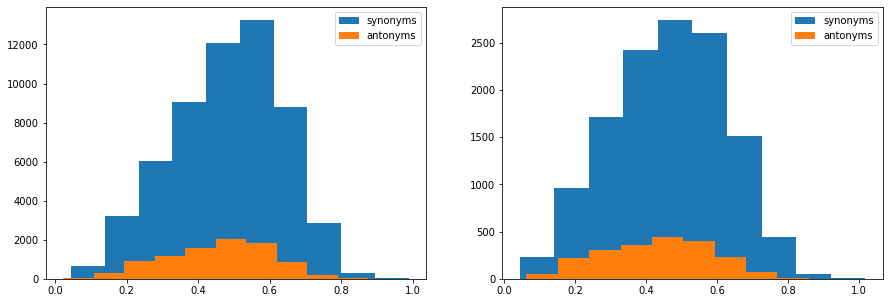

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
show_raw_distrib(iter_train, fst_emb)
plt.subplot(122)
show_raw_distrib(iter_test, fst_emb)

In [8]:
# plt.figure(figsize=(15, 5))
# plt.subplot(121)
# show_raw_distrib(graph_train, fst_emb)
# plt.subplot(122)
# show_raw_distrib(graph_test, fst_emb)

In [9]:
train_triplet_dataloader = torch.utils.data.DataLoader(TripletDataset(iter_train, fst_emb, is_triplet=True), 
                                                batch_size=64, 
                                                shuffle=False, 
                                                num_workers=0)

train_pair_dataloader = torch.utils.data.DataLoader(TripletDataset(iter_train, fst_emb, is_triplet=False, stack_samples=False), 
                                                batch_size=64, 
                                                shuffle=False, 
                                                num_workers=0)

val_triplet_dataloader = torch.utils.data.DataLoader(TripletDataset(iter_test, fst_emb, is_triplet=True), 
                                                batch_size=64, 
                                                shuffle=False, 
                                                num_workers=0)

val_pair_dataloader = torch.utils.data.DataLoader(TripletDataset(iter_test, fst_emb, is_triplet=False,stack_samples=False), 
                                                batch_size=64, 
                                                shuffle=False, 
                                                num_workers=0)


test_dataset = TripletDataset(iter_test, fst_emb, is_triplet=False, stack_samples=False)




100%|████████████████████████████████████████████████████████████████████████| 14788/14788 [00:00<00:00, 449319.18it/s]


 ### Triplet Net 

In [10]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
loss_fn = TripletLoss(margin=1.)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.to(device='cuda');

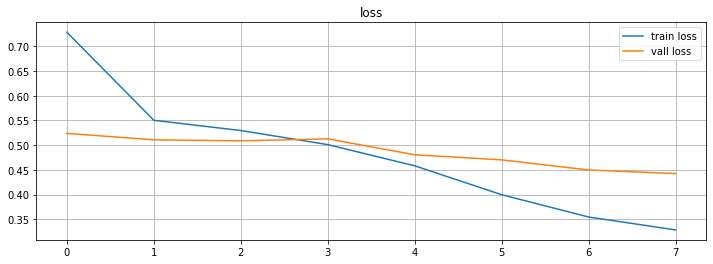

Epoch 0
Train Loss: 0.7283 | Val Loss: 0.5237

Epoch 1
Train Loss: 0.5503 | Val Loss: 0.5107

Epoch 2
Train Loss: 0.5295 | Val Loss: 0.5087

Epoch 3
Train Loss: 0.5010 | Val Loss: 0.5127

Epoch 4
Train Loss: 0.4581 | Val Loss: 0.4805

Epoch 5
Train Loss: 0.3996 | Val Loss: 0.4701

Epoch 6
Train Loss: 0.3546 | Val Loss: 0.4497

Epoch 7
Train Loss: 0.3284 | Val Loss: 0.4425



In [11]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_triplet_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 8)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 232/232 [00:02<00:00, 79.28it/s]


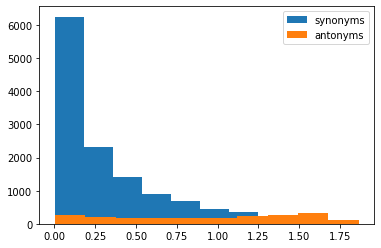

In [12]:
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)

In [13]:
x_fasttext, x_model, x_model_fasttest, y = get_embedding_for_test_task(model, test_dataset)

100%|███████████████████████████████████████████████████████████████████████████| 14788/14788 [00:14<00:00, 987.51it/s]


In [14]:
print_score(x_model, x_fasttext, x_model_fasttest, y)

LogisticRegression
model
0.7053658757547456 [0.68448767 0.72536643 0.70624352]
fasttext
0.7287298225719504 [0.69618811 0.70870415 0.7812972 ]
fasttext + model
0.7341195807290473 [0.7050304  0.71375447 0.78357387]

XGBoost
model
0.8420094312414297 [0.84695458 0.87611618 0.80295754]
fasttext
0.7315159727694271 [0.66798902 0.72997011 0.79658878]
fasttext + model
0.829241343879778 [0.80411077 0.8332668  0.85034646]


### CosTriplet Net

In [15]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device='cuda');
loss_fn = TripletCosLoss(margin=1.)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

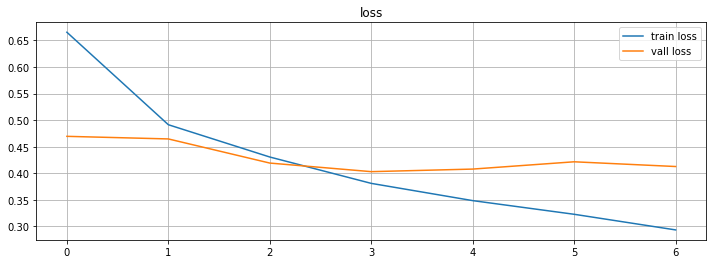

Epoch 0
Train Loss: 0.6653 | Val Loss: 0.4696

Epoch 1
Train Loss: 0.4914 | Val Loss: 0.4647

Epoch 2
Train Loss: 0.4307 | Val Loss: 0.4193

Epoch 3
Train Loss: 0.3811 | Val Loss: 0.4031

Epoch 4
Train Loss: 0.3486 | Val Loss: 0.4080

Epoch 5
Train Loss: 0.3230 | Val Loss: 0.4217

Epoch 6
Train Loss: 0.2936 | Val Loss: 0.4128



In [16]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_triplet_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 7)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 232/232 [00:02<00:00, 79.02it/s]


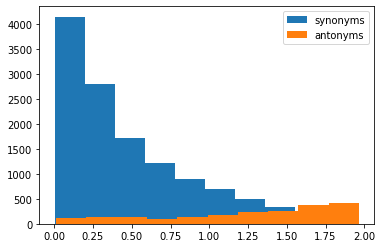

In [17]:
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)

In [18]:
x_fasttext, x_model, x_model_fasttest, y = get_embedding_for_test_task(model, test_dataset)

100%|███████████████████████████████████████████████████████████████████████████| 14788/14788 [00:14<00:00, 987.12it/s]


In [19]:
print_score(x_model, x_fasttext, x_model_fasttest, y)

LogisticRegression
model
0.7053966077036847 [0.69053934 0.70500405 0.72064643]
fasttext
0.7287298225719504 [0.69618811 0.70870415 0.7812972 ]
fasttext + model
0.7345441129666023 [0.70520973 0.71340426 0.78501836]

XGBoost
model
0.8660332756657959 [0.84953293 0.89330463 0.85526227]
fasttext
0.7315159727694271 [0.66798902 0.72997011 0.79658878]
fasttext + model
0.8422327900596583 [0.81007497 0.8472028  0.86942059]


### SiameseNet

In [20]:
model = SiameseNet(EmbeddingNet()).to(device='cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

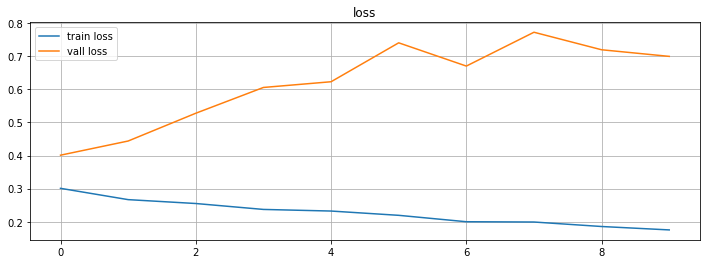

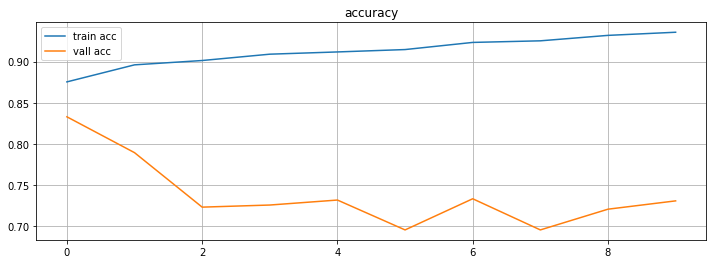

Epoch 0
Train Loss: 0.3008 | Val Loss: 0.4010
Train Acc: 0.8754 | Val Acc: 0.8330

Epoch 1
Train Loss: 0.2666 | Val Loss: 0.4438
Train Acc: 0.8961 | Val Acc: 0.7894

Epoch 2
Train Loss: 0.2549 | Val Loss: 0.5278
Train Acc: 0.9014 | Val Acc: 0.7232

Epoch 3
Train Loss: 0.2370 | Val Loss: 0.6057
Train Acc: 0.9091 | Val Acc: 0.7258

Epoch 4
Train Loss: 0.2321 | Val Loss: 0.6230
Train Acc: 0.9118 | Val Acc: 0.7318

Epoch 5
Train Loss: 0.2192 | Val Loss: 0.7406
Train Acc: 0.9147 | Val Acc: 0.6955

Epoch 6
Train Loss: 0.1998 | Val Loss: 0.6704
Train Acc: 0.9234 | Val Acc: 0.7334

Epoch 7
Train Loss: 0.1989 | Val Loss: 0.7726
Train Acc: 0.9253 | Val Acc: 0.6955

Epoch 8
Train Loss: 0.1854 | Val Loss: 0.7196
Train Acc: 0.9319 | Val Acc: 0.7207

Epoch 9
Train Loss: 0.1751 | Val Loss: 0.6997
Train Acc: 0.9357 | Val Acc: 0.7308



In [21]:
fit(train_dataloader=train_pair_dataloader, 
    val_dataloader=val_pair_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 10,
   with_acc=True)

In [22]:
# fit(train_dataloader=train_dataloader, 
#     val_dataloader=val_dataloader, 
#     model=model,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     n_epochs = 2)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 232/232 [00:02<00:00, 78.75it/s]


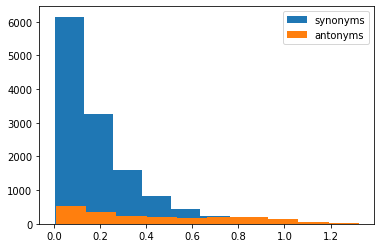

In [23]:
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)

In [24]:
x_fasttext, x_model, x_model_fasttest, y = get_embedding_for_test_task(model, test_dataset)

100%|███████████████████████████████████████████████████████████████████████████| 14788/14788 [00:15<00:00, 981.96it/s]


In [25]:
print_score(x_model, x_fasttext, x_model_fasttest, y)

LogisticRegression
model
0.7318342135057806 [0.70621513 0.69534988 0.79393763]
fasttext
0.7287298225719504 [0.69618811 0.70870415 0.7812972 ]
fasttext + model
0.7432994615240464 [0.70882438 0.71743904 0.80363496]

XGBoost
model
0.8674635247305789 [0.86027727 0.87145187 0.87066143]
fasttext
0.7315159727694271 [0.66798902 0.72997011 0.79658878]
fasttext + model
0.8533468444254959 [0.82266295 0.85971091 0.87766667]


### SiamTripletNet

In [26]:
embedding_net = EmbeddingNet()
classification_net = ClassificationeNet_v3()
model = TripletNet_v3(embedding_net, classification_net)
model.to(device='cuda');

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.01)#lr=0.001
loss_fn = nn.CrossEntropyLoss()

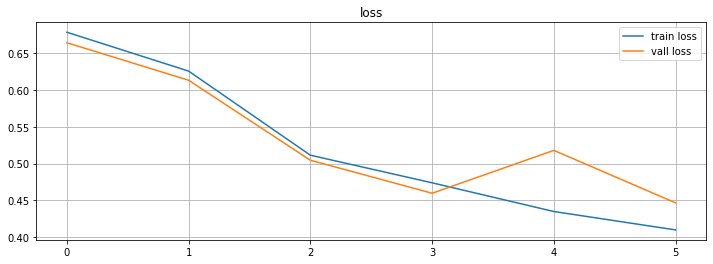

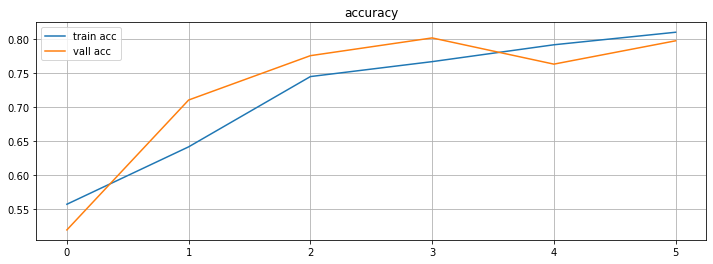

Epoch 0
Train Loss: 0.6785 | Val Loss: 0.6642
Train Acc: 0.5566 | Val Acc: 0.5188

Epoch 1
Train Loss: 0.6257 | Val Loss: 0.6132
Train Acc: 0.6411 | Val Acc: 0.7100

Epoch 2
Train Loss: 0.5113 | Val Loss: 0.5045
Train Acc: 0.7445 | Val Acc: 0.7753

Epoch 3
Train Loss: 0.4738 | Val Loss: 0.4596
Train Acc: 0.7665 | Val Acc: 0.8014

Epoch 4
Train Loss: 0.4348 | Val Loss: 0.5179
Train Acc: 0.7913 | Val Acc: 0.7628

Epoch 5
Train Loss: 0.4098 | Val Loss: 0.4465
Train Acc: 0.8097 | Val Acc: 0.7971



In [28]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_pair_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 6,
    post_classification=True,
    with_acc=True)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 232/232 [00:02<00:00, 79.28it/s]


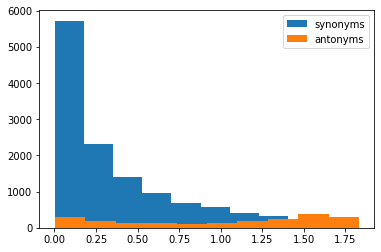

In [29]:
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)

In [30]:
x_fasttext, x_model, x_model_fasttest, y = get_embedding_for_test_task(model, test_dataset)

100%|███████████████████████████████████████████████████████████████████████████| 14788/14788 [00:14<00:00, 986.07it/s]


In [31]:
print_score(x_model, x_fasttext, x_model_fasttest, y)

LogisticRegression
model
0.7475562410007246 [0.72268389 0.73948396 0.78050087]
fasttext
0.7287298225719504 [0.69618811 0.70870415 0.7812972 ]
fasttext + model
0.7473039540717911 [0.72228774 0.72473185 0.79489227]

XGBoost
model
0.861415937935488 [0.85429956 0.87140155 0.8585467 ]
fasttext
0.7315159727694271 [0.66798902 0.72997011 0.79658878]
fasttext + model
0.8493066570023741 [0.82570618 0.84900743 0.87320636]


### SiamTriplet with annealing

In [32]:
embedding_net = EmbeddingNet()
classification_net = ClassificationeNet_v3()
model = TripletNet_v3(embedding_net, classification_net)
model.to(device='cuda');

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.01)#lr=0.001
loss_fn = nn.CrossEntropyLoss()

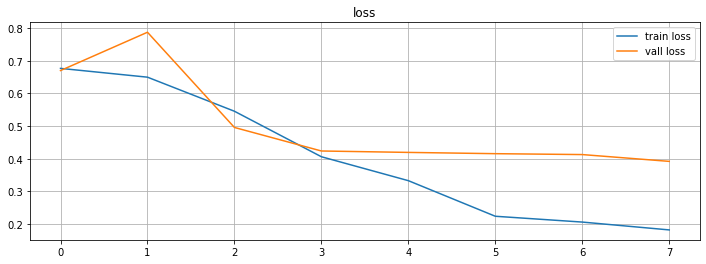

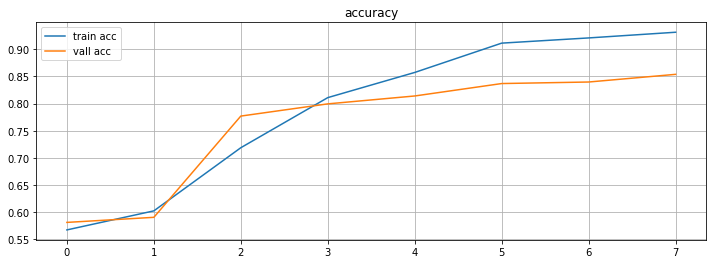

Epoch 0
Train Loss: 0.6765 | Val Loss: 0.6698
Train Acc: 0.5671 | Val Acc: 0.5810

Epoch 1
Train Loss: 0.6496 | Val Loss: 0.7870
Train Acc: 0.6022 | Val Acc: 0.5903

Epoch 2
Train Loss: 0.5453 | Val Loss: 0.4957
Train Acc: 0.7186 | Val Acc: 0.7769

Epoch 5
Train Loss: 0.4062 | Val Loss: 0.4237
Train Acc: 0.8109 | Val Acc: 0.7994

Epoch 7
Train Loss: 0.3329 | Val Loss: 0.4194
Train Acc: 0.8573 | Val Acc: 0.8139

Epoch 11
Train Loss: 0.2241 | Val Loss: 0.4155
Train Acc: 0.9113 | Val Acc: 0.8368

Epoch 13
Train Loss: 0.2063 | Val Loss: 0.4128
Train Acc: 0.9209 | Val Acc: 0.8396

Epoch 16
Train Loss: 0.1823 | Val Loss: 0.3920
Train Acc: 0.9314 | Val Acc: 0.8538



In [34]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_pair_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 50,
    post_classification=True,
    with_acc=True,
    with_scheduler=True)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 232/232 [00:02<00:00, 79.10it/s]


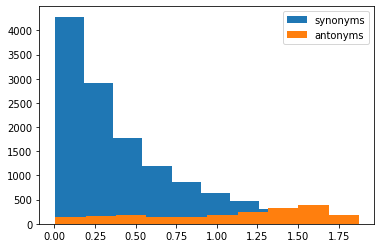

In [35]:
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)

In [36]:
x_fasttext, x_model, x_model_fasttest, y = get_embedding_for_test_task(model, test_dataset)

100%|███████████████████████████████████████████████████████████████████████████| 14788/14788 [00:15<00:00, 985.61it/s]


In [37]:
print_score(x_model, x_fasttext, x_model_fasttest, y)

LogisticRegression
model
0.7440048236284514 [0.72494765 0.73432421 0.7727426 ]
fasttext
0.7287298225719504 [0.69618811 0.70870415 0.7812972 ]
fasttext + model
0.7433316795654826 [0.72007666 0.72004019 0.78987819]

XGBoost
model
0.8717386100702077 [0.86287065 0.88481155 0.86753363]
fasttext
0.7315159727694271 [0.66798902 0.72997011 0.79658878]
fasttext + model
0.8544669849983452 [0.83406299 0.8537592  0.87557877]
